# Implementación punto 3.1.3

Se calcula el ángulo de elevación de cada imagen.

In [1]:
import cv2
import math
import numpy as np
import os
from statistics import mean
from IPython.display import Image  # Import the Image class

In [2]:
def create_mask_from_img (image):
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY)
    return mask

In [3]:
def draw_axes(img, img_ellipse):
    axes, center, direction, _ = img_ellipse
    a, b = axes
    direction_a, direction_b = direction

    print(a, b, center, direction_a, direction_b)

    end_point_a = (int(center[0] + a * direction_a[0]), int(center[1] + a * direction_a[1]))
    end_point_b = (int(center[0] + b * direction_b[0]), int(center[1] + b * direction_b[1]))

    font = cv2.FONT_HERSHEY_COMPLEX_SMALL
    font_scale = 1
    font_color = (255, 0, 0)  # Red color in BGR format
    thickness = 2

    major_letter = (
        int((center[0] + a * direction_a[0])),
        int((center[1] + a * direction_a[1]))
    )
    minor_letter = (
        int((center[0] + b * direction_b[0])),
        int((center[1] + b * direction_b[1]))
    )

    cv2.line(img, center, end_point_a, (0, 255, 0), 2)
    cv2.line(img, center, end_point_b, (0, 255, 0), 2)
    cv2.putText(img, "a", major_letter, font, font_scale, font_color, thickness, cv2.LINE_AA)
    cv2.putText(img, "b", minor_letter, font, font_scale, font_color, thickness, cv2.LINE_AA)

In [4]:
def calculate_ellipse_from_mask(binary_mask):
    mask = binary_mask.astype(np.int32)
    y_indices, x_indices = np.indices(mask.shape)
    positive_pixels = mask == 255
    result_x = x_indices[positive_pixels]
    result_y = y_indices[positive_pixels]
    n = len(result_x)

    sx = np.sum(result_x)
    cx = sx / len(result_x)
    sxx = np.sum(np.square(result_x))

    sy = np.sum(result_y)
    cy = sy / len(result_y)
    syy = np.sum(np.square(result_y))

    mult_list = [x * y for x, y in zip(result_x, result_y)]
    sxy = np.sum(mult_list)

    sigma_x2 = (sxx / n) - cx ** 2
    sigma_y2 = (syy / n) - cy ** 2
    sigma_xy = (sxy / n) - (cx * cy)

    cov_matrix = [[sigma_x2, sigma_xy], [sigma_xy, sigma_y2]]
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    direction_a = eigenvectors[0] / np.linalg.norm(eigenvectors[0])
    direction_b = eigenvectors[1] / np.linalg.norm(eigenvectors[1])

    a = int(2 * (math.sqrt(abs(eigenvalues[0]))))  # semi major axis of projected ellipse
    b = int(2 * (math.sqrt(abs(eigenvalues[1]))))  # semi minor axis of projected ellipse

    return [a, b], [int(cx), int(cy)], [direction_a, direction_b] ,[*eigenvectors],

In [5]:
def join_images(images):
    min_height = min([image.shape[0] for image in images])
    resized_imgs = [cv2.resize(image, (image.shape[1], min_height)) for image in images]
    joined_imgs = cv2.hconcat(resized_imgs)
    return joined_imgs

In [6]:
def estimate_b_axe_trend(b_axes):
    mean_seq = mean(b_axes)
    if b_axes[0] < mean_seq < b_axes[-1]:
        return True   # "Ascending"
    elif b_axes[0] > mean_seq > b_axes[-1]:
        return False  # "Descending"
    else:
        return None   # No clear trend

In [7]:
def write_angle_on_img(img_to_draw, angle_text, org, color = (255, 0, 0)):
    font = cv2.FONT_HERSHEY_SIMPLEX
    # org = (50, 50)
    fontScale = 0.5
    thickness = 2

    cv2.putText(img_to_draw, str(angle_text), org, font, fontScale, color, thickness, cv2.LINE_AA)
    return img_to_draw

In [8]:
def calculate_oblate():
    a = mean(axe_a_all_views)
    b = min(axe_b_all_views)
    return [a, b]

In [9]:
# Declare vars for this angle estimation test
fruit_folder = "../data/tomatoes/obj0001/"
axe_a_all_views = []
axe_b_all_views = []
oblate_spheroid = [] # A, B
prolate_spheroid = [] # A, B
ellipse_all_views = []
oblate_angles = []

# STORE LIST OF IMAGES WITH EDITED ANGLES
oblate_edited_imgs = []
prolate_edited_imgs = []
oblate_edited_axes_imgs = []


In [10]:
# CON COV MATRIX AXES
image_files = sorted([file for file in os.listdir(fruit_folder)])
for image_name in image_files:
    file_path = os.path.join(fruit_folder, image_name)
    img = cv2.imread(file_path)
    mask = create_mask_from_img(img)
    ellipse = calculate_ellipse_from_mask(mask)
    axes_length, _, _, _ = ellipse
    major_axis_length, minor_axis_length = axes_length
    axe_b_all_views.append(minor_axis_length)
    axe_a_all_views.append(major_axis_length)
    ellipse_all_views.append(ellipse)

In [11]:
oblate_spheroid = calculate_oblate()

# Angle estimation for each img

In [12]:
def prev_post_values_b(current_b_index, b_list, steps, direction = 1):
    enlarged_b_list = [*b_list, *b_list]
    enlarged_index = current_b_index + len(b_list) - 1 if current_b_index < (len(b_list) / 2) else current_b_index
    total_steps = 1 + steps

    if direction < 0:
        b_axes = enlarged_b_list[(enlarged_index - total_steps) : enlarged_index]
    elif direction > 0:
        b_axes = enlarged_b_list[enlarged_index : (enlarged_index + total_steps)]
    else:
        b_axes = enlarged_b_list[enlarged_index - 2 : enlarged_index + 2]
    return b_axes

In [13]:
def choose_smooth_angle(calc_angle):
    diff_0 = abs(calc_angle - 0)
    diff_90 = abs(calc_angle - 90)
    diff_minus_90 = abs(calc_angle + 90)

    if diff_0 < diff_90 and diff_0 < diff_minus_90 and diff_0 < 40:  # Lower than 40 degrees of difference
        return 0
    elif diff_90 < diff_0 and diff_90 < diff_minus_90:
        return 90
    else:
        return -90

In [14]:
def get_trend_for_view(index_view, direction = 1, step = 0):
    b_axes = prev_post_values_b(index_view, axe_b_all_views, step, direction)
    trend = estimate_b_axe_trend(b_axes)
    if trend is None:
        return get_trend_for_view(index_view, 1, step + 1)
    else:
        return trend

In [15]:
# CALCULATE THE NEXT ANGLE IF NEEDED
def angle_estimation(index_view):
    if oblate_angles[index_view] != -1: return oblate_angles[index_view]   # Return if already calculated in another cycle

    #Spheroid values
    a, b = oblate_spheroid
    b_curr = axe_b_all_views[index_view]

    fruit_rot = 'downwards'
    curr_cos_theta = math.sqrt((pow(b_curr, 2) - pow(b, 2))/(pow(a, 2) - pow(b, 2)))

    curr_theta_pos = np.degrees(np.arccos(curr_cos_theta))
    curr_theta_neg = np.degrees(-np.arccos(curr_cos_theta))
    current_view_angles = (curr_theta_pos, curr_theta_neg)

    rotation_per_view = 360 / len(axe_b_all_views) + 5
    correct_theta = lambda ascending_sequence: current_view_angles[0] if ascending_sequence and (fruit_rot == 'downwards') or (not ascending_sequence) and (fruit_rot == 'upwards') else current_view_angles[1]

    calculated_angle_without_sec_amb = correct_theta(get_trend_for_view(index_view, 0))
    write_angle_on_img(img, calculated_angle_without_sec_amb, (50, 100), (0, 0, 255)) # (image, angle to write, color of the text)

    # Second ambiguity
    if 0 <= abs(current_view_angles[0]) <= rotation_per_view or abs(90 - rotation_per_view) <= abs(current_view_angles[0]) >= 0:
        if index_view < len(image_files) - 1:
            temp_correct_theta_value = correct_theta(get_trend_for_view(index_view, 0))
            oblate_angles[index_view] = temp_correct_theta_value
            next_view_angle = angle_estimation(index_view + 1)
            if next_view_angle in [0.0, 90.0, -90.0] or oblate_angles[index_view - 1] in [0.0, 90.0, -90.0]:
                theta = correct_theta(get_trend_for_view(index_view, 0))
            else:
                theta = choose_smooth_angle(oblate_angles[index_view - 1])
        else:
            theta = correct_theta(get_trend_for_view(index_view, 0))
    else:
        theta = correct_theta(get_trend_for_view(index_view, 0))

    oblate_angles[index_view] = theta
    return theta

In [16]:
oblate_angles = [-1 for element in range(len(image_files))]
for index, image_name in enumerate(image_files):
    # Read current image
    file_path = os.path.join(fruit_folder, image_name)
    img = cv2.imread(file_path)
    img_axes = cv2.imread(file_path)

    # Estimate angle
    oblate_angle = angle_estimation(index)

    write_angle_on_img(img, oblate_angle, (50, 50), (0, 255, 0)) # (image, angle to write, color of the text)
    oblate_edited_imgs.append(img)
    oblate_edited_axes_imgs.append(img_axes)

    draw_axes(img_axes, ellipse_all_views[index])

157 150 [183, 175] [0.96815521 0.25035072] [-0.25035072  0.96815521]
157 148 [183, 177] [0.98144254 0.19175648] [-0.19175648  0.98144254]
159 142 [178, 165] [0.99875538 0.04987667] [-0.04987667  0.99875538]
164 122 [182, 149] [ 0.99172708 -0.12836432] [0.12836432 0.99172708]
160 137 [183, 158] [ 0.97942624 -0.20180249] [0.20180249 0.97942624]
159 146 [173, 173] [ 0.93627851 -0.35125853] [0.35125853 0.93627851]
158 151 [186, 177] [ 0.93489644 -0.35492061] [0.35492061 0.93489644]
157 152 [179, 174] [ 0.98804006 -0.15419739] [0.15419739 0.98804006]
156 148 [183, 163] [0.98832714 0.15234653] [-0.15234653  0.98832714]
158 140 [180, 163] [0.99737616 0.07239331] [-0.07239331  0.99737616]
161 125 [185, 144] [0.99853034 0.05419566] [-0.05419566  0.99853034]
158 137 [173, 155] [0.99933075 0.03657945] [-0.03657945  0.99933075]
156 151 [181, 176] [0.97840364 0.20670344] [-0.20670344  0.97840364]
156 151 [173, 175] [0.94849305 0.31679794] [-0.31679794  0.94849305]
156 150 [179, 178] [0.93983499 0.3

In [17]:
# JOIN AND SHOW ALL VIEWS WITH ANGLES
joined_oblate_images = join_images(oblate_edited_imgs)
cv2.imwrite("oblate_angles.png", joined_oblate_images)

joined_oblate_axes_images = join_images(oblate_edited_axes_imgs)
cv2.imwrite("oblate_axes.png" , joined_oblate_axes_images)

True

### Imagen de angulos para esferoide oblate

In [18]:
# print(axe_b_all_views)

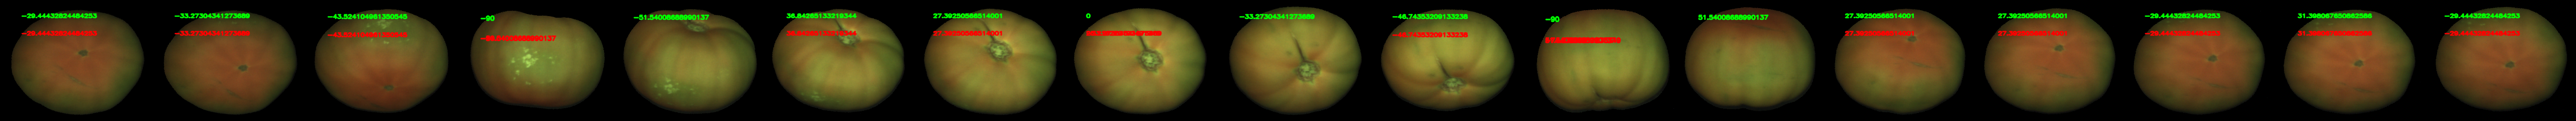

In [19]:
large_image_path = 'oblate_angles.png'
Image(filename=large_image_path, width=2000)

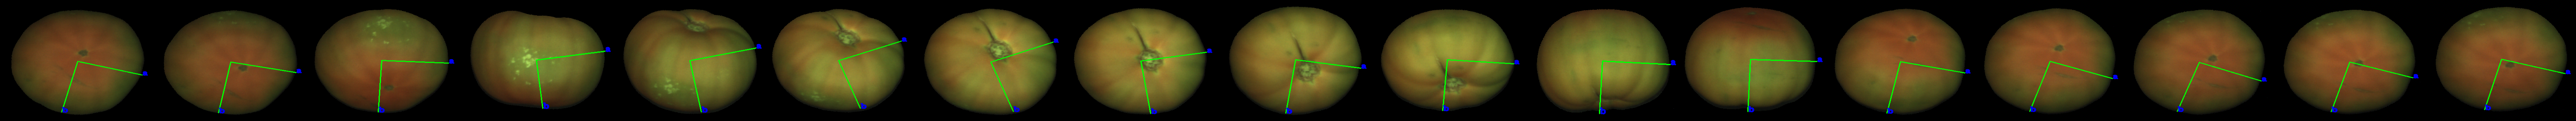

In [20]:
large_image_path = 'oblate_axes.png'
Image(filename=large_image_path, width=2000)